# NUWE Schnider Hackaton - Data Science - Zero deforestation mission
## Team name: ZeroOne
#### Members:
- Sai Thejeshwar
- Abhay Joshi

#### This notebook does an EDA on the given dataset

# Import libraries

In [ ]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2 
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
%cd /gdrive/My Drive/Deforestation

#### Handler Functions

In [ ]:
def normalizeMinMax(image):
    return (image - image.min()) / (image.max() - image.min())

In [ ]:
def channels_hist(image_0, bins = 256, range = (0,256)):
    # tuple to select colors of each channel line
    colors = ("red", "green", "blue")

    # create the histogram plot, with three lines, one for
    # each color
    plt.figure()
    plt.xlim([range[0], range[1]])
    for channel_id, color in enumerate(colors):
        histogram, bin_edges = np.histogram(
            image_0[:, :, channel_id], bins=bins, range=range
        )
        plt.plot(bin_edges[0:-1], histogram, color=color)

    plt.title("Color Histogram")
    plt.xlabel("Color value")
    plt.ylabel("Pixel count")

In [ ]:
def read_images(df):
    images = np.zeros((len(df), 332,332, 3))
    for e,path in enumerate(df['images_path']):
        images[e,:,:,:] = cv2.imread('data/deforest/'+path)
    images = images.astype(np.uint8)
    return images

# 1. EDA

Load csv

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
label_to_name = {
    0: 'Plantation', 
    1: 'Grassland/Shrubland', 
    2: 'Smallholder Agriculture'
}
train['label_name'] = train['label'].map(label_to_name)

Load images

In [ ]:
images = read_images(train)

#### Distribución targets

<AxesSubplot:>

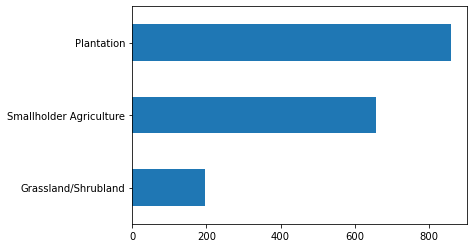

In [ ]:
train['label_name'].value_counts().sort_values().plot(kind = 'barh')

We will have to bear in mind that this is an unbalanced dataset.

#### Distribución pixeles imagenes

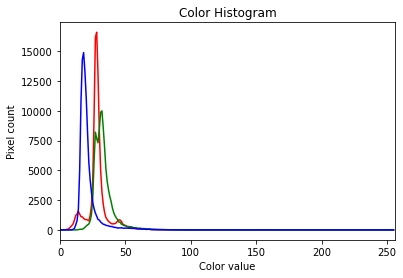

In [ ]:
channels_hist(images[0])

#### Normalize 

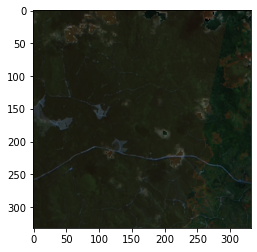

In [ ]:
plt.imshow(images[0])

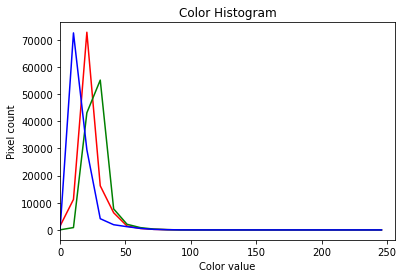

In [ ]:
channels_hist(images[0], 25, (0,256))

In [ ]:
minmaxnorm = normalizeMinMax(images[0])

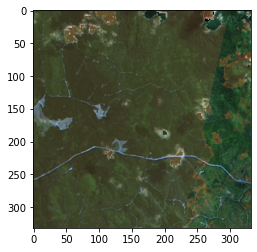

In [ ]:
plt.imshow(minmaxnorm)

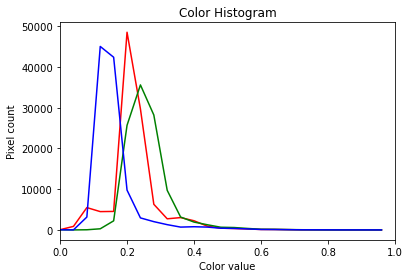

In [ ]:
channels_hist(minmaxnorm, 25, (0,1))

In [ ]:
imagesNorm = normalizeMinMax(images)

In [ ]:
mu = imagesNorm.reshape(1714*332*332, 3).mean(axis = 0)
std = imagesNorm.reshape(1714*332*332, 3).std(axis = 0) 
print(f'Mean datos by channel: {mu}\Data std by channel: {std}')

Mean datos by channel: [0.05988506 0.11918356 0.08738288]\Data std by channel: [0.0412134  0.04506581 0.05181303]


Means and std by class

In [ ]:
plantation = train[train['label'] == 0]
grassland = train[train['label'] == 1]
smallholder = train[train['label'] == 2]

In [ ]:
plantation_images = read_images(plantation)
grassland_images = read_images(grassland)
smallholder_images = read_images(smallholder)

In [ ]:
plantation_mean = plantation_images.reshape(len(plantation_images) * 332*332,3).mean(axis = 0)
grassland_mean = grassland_images.reshape(len(grassland_images) * 332*332,3).mean(axis = 0)
smallholder_mean = smallholder_images.reshape(len(smallholder_images) * 332*332,3).mean(axis = 0)

In [ ]:
plantation_std = plantation_images.reshape(len(plantation_images) * 332*332,3).std(axis = 0)
grassland_std = grassland_images.reshape(len(grassland_images) * 332*332,3).std(axis = 0)
smallholder_std = smallholder_images.reshape(len(smallholder_images) * 332*332,3).std(axis = 0)

In [ ]:
df  = pd.DataFrame({'labels': ['Plantation','Grassland/Shrubland','Smallholder Agriculture'], 
    'Rmean' : [plantation_mean[0], smallholder_mean[0], grassland_mean[0]],
    'Gmean' : [plantation_mean[1], smallholder_mean[1], grassland_mean[1]],
    'Bmean' : [plantation_mean[2], smallholder_mean[2], grassland_mean[2]],
    'Rstd' : [plantation_std[0], smallholder_std[0], grassland_std[0]],
    'Gstd' : [plantation_std[1], smallholder_std[1], grassland_std[1]],
    'Bstd' : [plantation_std[2], smallholder_std[2], grassland_std[2]]})

In [ ]:
df

,labels,Rmean,Gmean,Bmean,Rstd,Gstd,Bstd
0,Plantation,15.725172,30.531295,23.042379,10.541464,11.677333,13.764905
1,Grassland/Shrubland,14.914524,30.421357,21.785901,10.571276,11.428999,12.921195
2,Smallholder Agriculture,14.472235,29.680570,20.616667,10.056842,10.836724,11.338517


#### Transformations

For model training, we will do a grid search to find the best image transformations. 
We are going to use: RandomEqualize, RandomAutocontrast,randomAdjustSharpness, randomSolarize, randomRotation, 

#### Year and class study

In [ ]:
grouped = train.groupby(['year', 'label_name'],as_index=False).agg(count = ('year','count'))

<AxesSubplot:xlabel='year', ylabel='count'>

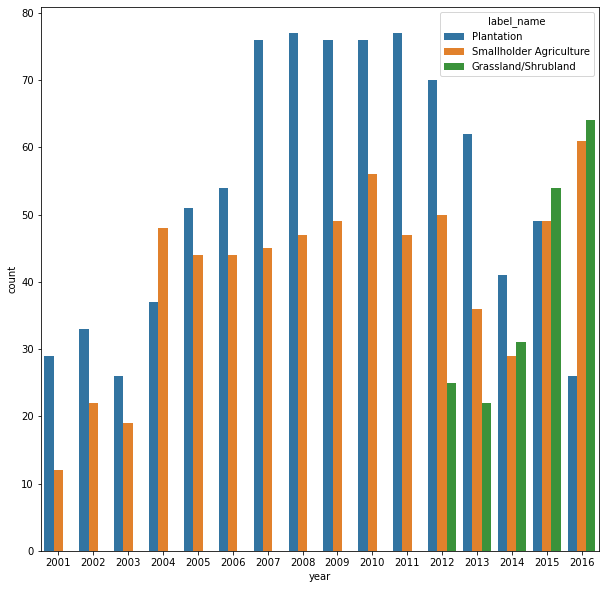

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(data = grouped, x="year", y="count", hue="label_name")

Year is an important feature, class 'Grassland' first appearence in 2012.

#### Lat, long class study

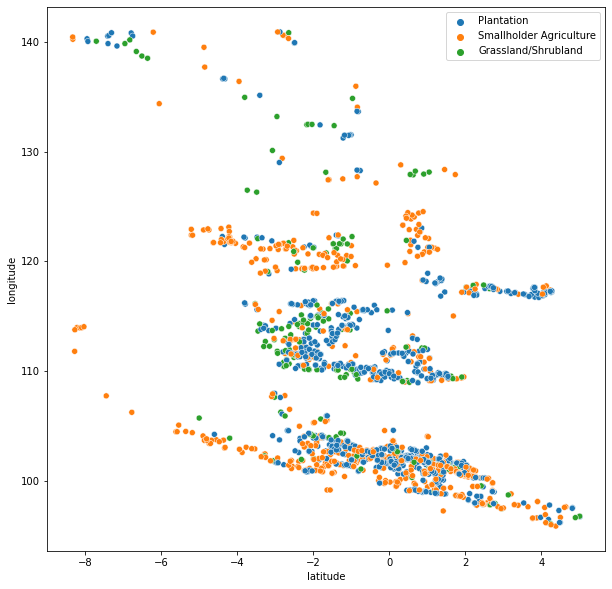

In [ ]:
plt.figure(figsize = (10,10))
g = sns.scatterplot(data = train, x="latitude", y = "longitude", hue="label_name")
g.legend_.set_title("")

There is no trivial class clustering by latitude, longitude